In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import json
import time

# Dataset paths
train_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/train'
val_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/test'

# Image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data generators
train_dataset = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)
val_dataset = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)

# Class names
class_names = list(train_dataset.class_indices.keys())

# Pretrained MobileNetV2 model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

# Model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Record start time
start_time = time.time()

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Record end time
training_time = time.time() - start_time

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on validation data
val_labels = val_dataset.classes  # Use val_dataset.classes directly
predictions = model.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Confusion matrix
confusion_mat = confusion_matrix(val_labels, predicted_labels)

# ROC and AUC computation
val_labels_one_hot = label_binarize(val_labels, classes=range(len(class_names)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(val_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Prepare results for JSON
results = {
    'accuracy': accuracy * 100,
    'training_time': training_time,
    'epochs': 10,
    'final_model_history': {
        'accuracy': history.history['accuracy'],
        'loss': history.history['loss'],
        'val_accuracy': history.history['val_accuracy'],
        'val_loss': history.history['val_loss']
    },
'class_names': class_names,
    'image_size': IMG_SIZE,
    'confusion_matrix': confusion_mat.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save results to a JSON file
json_file_path = f'/kaggle/working/MobileNetV2_Results_{IMG_SIZE[0]}.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f"Results saved to {json_file_path}")


Found 2390 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 533ms/step - accuracy: 0.2973 - loss: 1.9576 - val_accuracy: 0.3383 - val_loss: 1.5790
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - accuracy: 0.3693 - loss: 1.7480 - val_accuracy: 0.3767 - val_loss: 1.4216
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.4337 - loss: 1.5682 - val_accuracy: 0.3933 - val_loss: 1.3763
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.4502 - loss: 1.4416 - val_accuracy: 0.4333 - val_loss: 1.3236
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.4729 - loss: 1.3400 - val_accuracy: 0.4517 - val_loss: 1.3123
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.4865 - loss: 1.3200 - val_accuracy: 0.4417 - val_loss: 1.3086
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.5003 - loss: 1.2538 - val_accuracy: 0.4467 - val_loss: 1.2944
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.5131 - loss: 1.2617 - val_accuracy: 0.460

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import json
import time

# Dataset paths
train_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/train'
val_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/test'

# Image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data generators
train_dataset = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)
val_dataset = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)

# Class names
class_names = list(train_dataset.class_indices.keys())

# Pretrained MobileNetV2 model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

# Model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Record start time
start_time = time.time()

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Record end time
training_time = time.time() - start_time

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on validation data
val_labels = val_dataset.classes  # Use val_dataset.classes directly
predictions = model.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Confusion matrix
confusion_mat = confusion_matrix(val_labels, predicted_labels)

# ROC and AUC computation
val_labels_one_hot = label_binarize(val_labels, classes=range(len(class_names)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(val_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Prepare results for JSON
results = {
    'accuracy': accuracy * 100,
    'training_time': training_time,
    'epochs': 10,
    'final_model_history': {
        'accuracy': history.history['accuracy'],
        'loss': history.history['loss'],
        'val_accuracy': history.history['val_accuracy'],
        'val_loss': history.history['val_loss']
    },
    'class_names': class_names,
    'image_size': IMG_SIZE,
    'confusion_matrix': confusion_mat.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save results to a JSON file
json_file_path = f'/kaggle/working/MobileNetV2_Results_{IMG_SIZE[0]}.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f"Results saved to {json_file_path}")


Found 2390 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


<ipython-input-2-91bc4b43ba91>:36: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 410ms/step - accuracy: 0.3508 - loss: 1.5941 - val_accuracy: 0.3467 - val_loss: 1.3702
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - accuracy: 0.3760 - loss: 1.4140 - val_accuracy: 0.3867 - val_loss: 1.2935
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.4301 - loss: 1.3023 - val_accuracy: 0.4183 - val_loss: 1.2478
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - accuracy: 0.4843 - loss: 1.2122 - val_accuracy: 0.4433 - val_loss: 1.2356
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.5126 - loss: 1.1540 - val_accuracy: 0.4367 - val_loss: 1.2279
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.5218 - loss: 1.1436 - val_accuracy: 0.4517 - val_loss: 1.2297
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - accuracy: 0.5249 - loss: 1.1241 - val_accuracy: 0.4633 - val_loss: 1.1987
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.5382 - loss: 1.0942 - val_accuracy: 0.470

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import json
import time

# Dataset paths
train_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/train'
val_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/test'

# Image size and batch size
IMG_SIZE = (512, 512)
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data generators
train_dataset = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)
val_dataset = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse'
)

# Class names
class_names = list(train_dataset.class_indices.keys())

# Pretrained MobileNetV2 model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

# Model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Record start time
start_time = time.time()

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Record end time
training_time = time.time() - start_time

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on validation data
val_labels = val_dataset.classes  # Use val_dataset.classes directly
predictions = model.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Confusion matrix
confusion_mat = confusion_matrix(val_labels, predicted_labels)

# ROC and AUC computation
val_labels_one_hot = label_binarize(val_labels, classes=range(len(class_names)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(val_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Prepare results for JSON
results = {
    'accuracy': accuracy * 100,
    'training_time': training_time,
    'epochs': 10,
    'final_model_history': {
        'accuracy': history.history['accuracy'],
        'loss': history.history['loss'],
        'val_accuracy': history.history['val_accuracy'],
        'val_loss': history.history['val_loss']
    },
    'class_names': class_names,
    'image_size': IMG_SIZE,
    'confusion_matrix': confusion_mat.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save results to a JSON file
json_file_path = f'/kaggle/working/MobileNetV2_Results_{IMG_SIZE[0]}.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f"Results saved to {json_file_path}")


Found 2390 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


<ipython-input-3-56923696fb7d>:36: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 704ms/step - accuracy: 0.2900 - loss: 1.4905 - val_accuracy: 0.2700 - val_loss: 1.3848
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 522ms/step - accuracy: 0.3818 - loss: 1.3319 - val_accuracy: 0.3483 - val_loss: 1.2947
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 553ms/step - accuracy: 0.4210 - loss: 1.2519 - val_accuracy: 0.3817 - val_loss: 1.2480
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 540ms/step - accuracy: 0.4637 - loss: 1.1585 - val_accuracy: 0.4067 - val_loss: 1.2143
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 534ms/step - accuracy: 0.4773 - loss: 1.1621 - val_accuracy: 0.4383 - val_loss: 1.1954
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 532ms/step - accuracy: 0.5206 - loss: 1.0796 - val_accuracy: 0.4667 - val_loss: 1.1653
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 534ms/step - accuracy: 0.5258 - loss: 1.0654 - val_accuracy: 0.4550 - val_loss: 1.1540
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 534ms/step - accuracy: 0.5316 - loss: 1.0420 - val_accuracy: 0.465

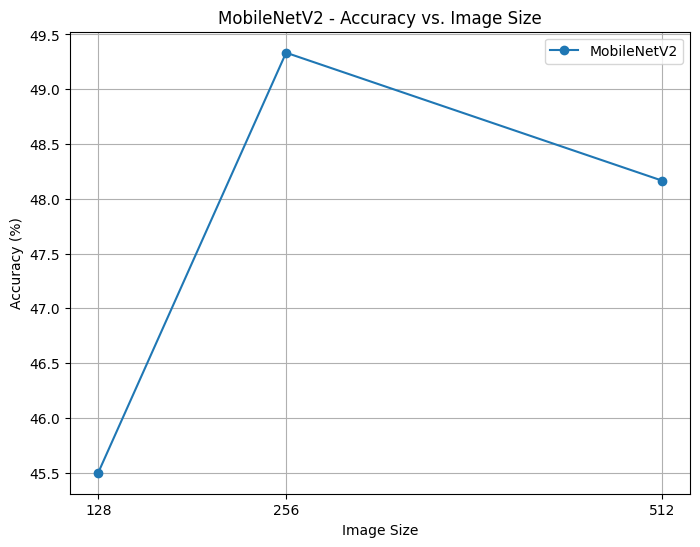

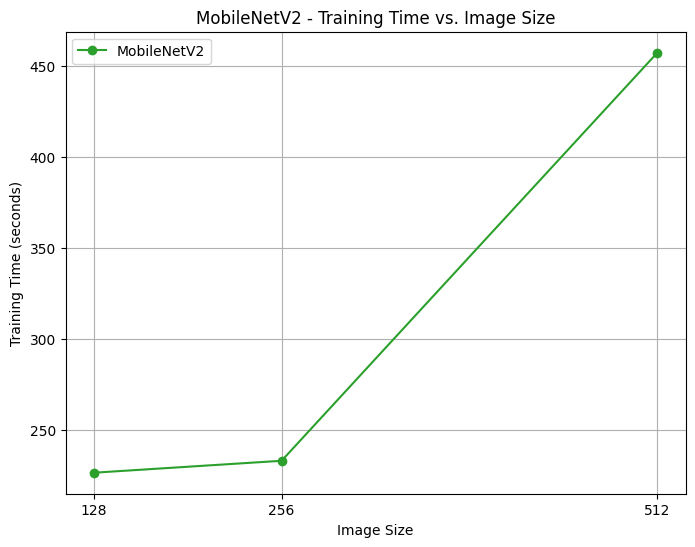

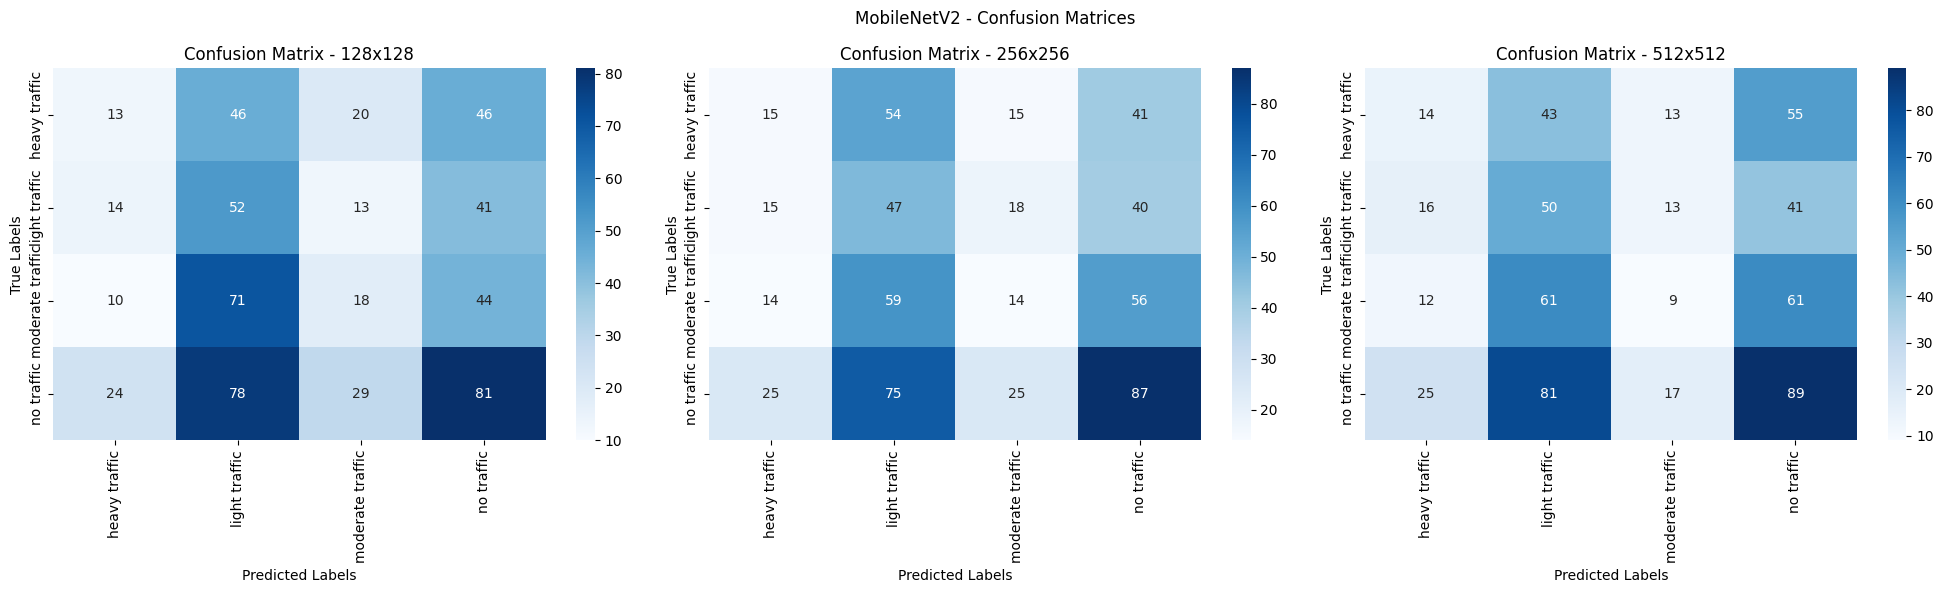

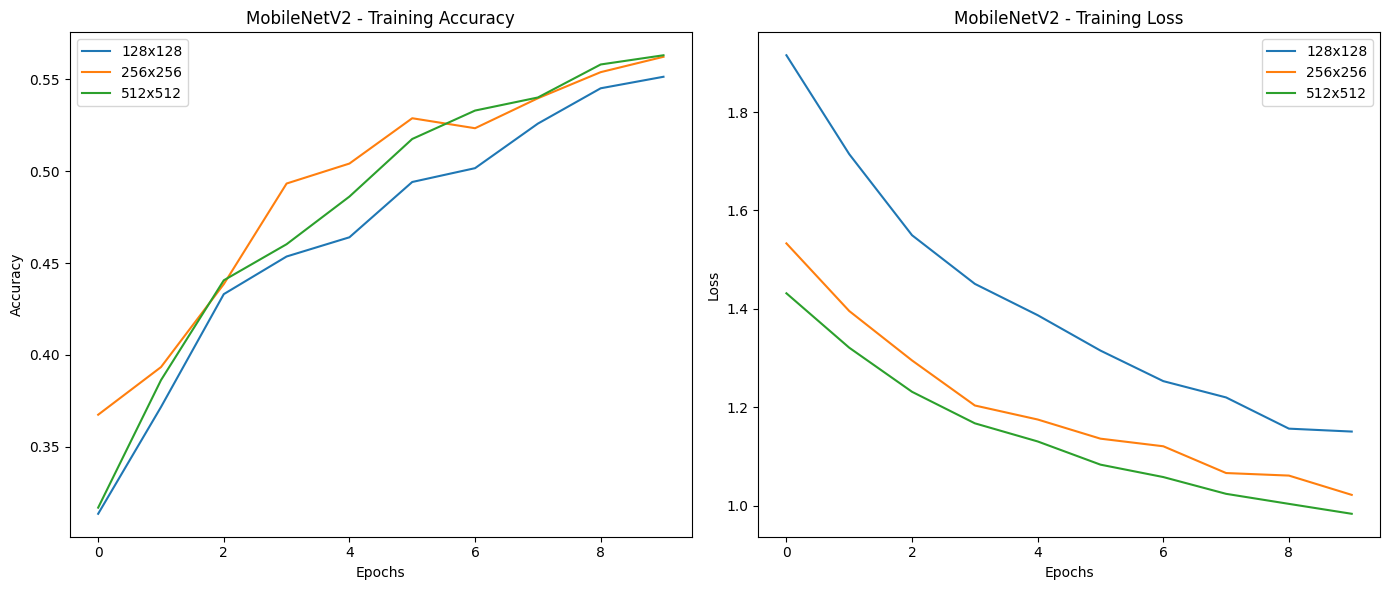

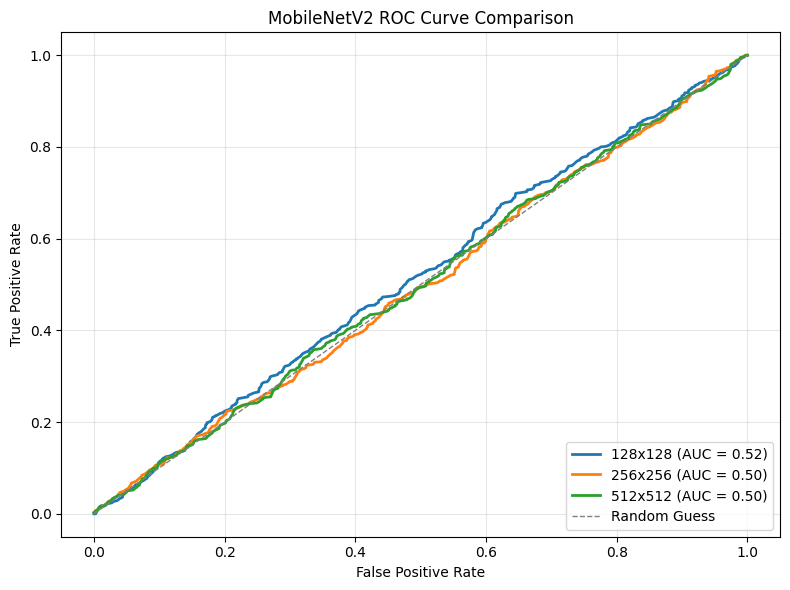

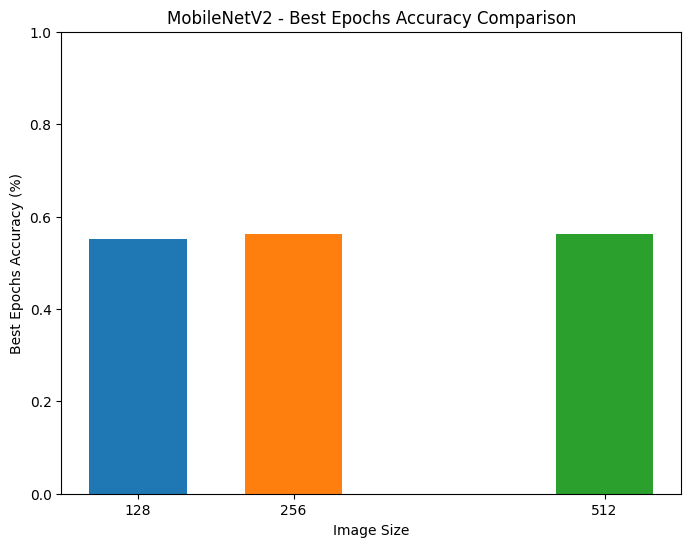

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.ticker as ticker

# Load the three JSON files
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Paths to the JSON files
json_files = [
    '/kaggle/working/MobileNetV2_Results_128.json',
    '/kaggle/working/MobileNetV2_Results_256.json',
    '/kaggle/working/MobileNetV2_Results_512.json'
]

# Load results for each image size
results_128 = load_json(json_files[0])
results_256 = load_json(json_files[1])
results_512 = load_json(json_files[2])

# Image sizes for x-axis
image_sizes = [128, 256, 512]

# Accuracy and Training Time
accuracy_values = [results_128['accuracy'], results_256['accuracy'], results_512['accuracy']]
training_times = [results_128['training_time'], results_256['training_time'], results_512['training_time']]

# Confusion Matrices
cm_128 = np.array(results_128['confusion_matrix'])
cm_256 = np.array(results_256['confusion_matrix'])
cm_512 = np.array(results_512['confusion_matrix'])

# Final Model Accuracy
final_accuracy = [
    np.max(results_128['final_model_history']['accuracy']),
    np.max(results_256['final_model_history']['accuracy']),
    np.max(results_512['final_model_history']['accuracy'])
]

# Class names
class_names = results_128['class_names']

# Plot 1: Accuracy vs. Image Size
plt.figure(figsize=(8, 6))
plt.plot(image_sizes, accuracy_values, marker='o', color='tab:blue', label='MobileNetV2')
plt.title('MobileNetV2 - Accuracy vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Accuracy (%)')
plt.xticks(image_sizes)
plt.grid(True)
plt.legend()
plt.savefig('MobileNetV2_Accuracy_vs_Image_Size.png')
plt.show()

# Plot 2: Training Time vs. Image Size
plt.figure(figsize=(8, 6))
plt.plot(image_sizes, training_times, marker='o', color='tab:green', label='MobileNetV2')
plt.title('MobileNetV2 - Training Time vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Training Time (seconds)')
plt.xticks(image_sizes)
plt.grid(True)
plt.legend()
plt.savefig('MobileNetV2_Training_Time_vs_Image_Size.png')
plt.show()

# Plot 3: Confusion Matrices (Side-by-Side Heatmaps)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, cm, size in zip(axes, [cm_128, cm_256, cm_512], image_sizes):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'Confusion Matrix - {size}x{size}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
plt.suptitle('MobileNetV2 - Confusion Matrices')
plt.tight_layout()
plt.savefig('MobileNetV2_Confusion_Matrices.png')
plt.show()

# Plot 4: Learning Curves (Accuracy and Loss vs. Epoch)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax[0].plot(results_128['final_model_history']['accuracy'], label='128x128', color='tab:blue')
ax[0].plot(results_256['final_model_history']['accuracy'], label='256x256', color='tab:orange')
ax[0].plot(results_512['final_model_history']['accuracy'], label='512x512', color='tab:green')
ax[0].set_title('MobileNetV2 - Training Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss
ax[1].plot(results_128['final_model_history']['loss'], label='128x128', color='tab:blue')
ax[1].plot(results_256['final_model_history']['loss'], label='256x256', color='tab:orange')
ax[1].plot(results_512['final_model_history']['loss'], label='512x512', color='tab:green')
ax[1].set_title('MobileNetV2 - Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.savefig('MobileNetV2_Learning_Curves.png')
plt.show()

# Plot 5: ROC Curve
plt.figure(figsize=(8, 6))

# Iterate over image sizes and their results
for size, results, color in zip(
    image_sizes,
    [results_128, results_256, results_512],
    ['tab:blue', 'tab:orange', 'tab:green']
):
    # Safely retrieve 'roc_curve' key
    roc_curve_data = results.get('roc_curve', {})
    fpr = roc_curve_data.get('fpr', [])
    tpr = roc_curve_data.get('tpr', [])
    auc_value = roc_curve_data.get('auc', None)

    if fpr and tpr and auc_value is not None:
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{size}x{size} (AUC = {auc_value:.2f})')
    else:
        print(f"Missing ROC data for image size {size}")

# Add plot details
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MobileNetV2 ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('MobileNetV2_ROC_Curve.png')
plt.show()

# Plot 6: Best Epochs Accuracy Comparison
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
bars = plt.bar(image_sizes, final_accuracy, color=colors, width=80)
plt.title('MobileNetV2 - Best Epochs Accuracy Comparison')
plt.xlabel('Image Size')
plt.ylabel('Best Epochs Accuracy (%)')
plt.xticks(image_sizes)
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(image_sizes))
plt.ylim(0, 1)
plt.savefig('MobileNetV2_Best_Epochs_Accuracy_Comparison.png')
plt.show()
